In [1]:
import matplotlib.pyplot as plt
import numpy as np

import msiwarp as mx
from msiwarp.util.warp import peak_density_mz

# setup input and output filepaths
fdir = 'datasets/orbitrap-desi/'
imzml_path = fdir + 'A67 CT S4-centroid.imzML'
fpath_triplets_raw = fdir + 'triplets_raw.dat'
fpath_triplets_warped = fdir + 'triplets_warped.dat'
fpath_dispersion_csv = fdir + 'results/dispersion_100.csv'
fpath_scatter = fdir + 'results/scatter'

sigma_1 = 3.0e-7
epsilon = 1.0
slack = 2.0 * epsilon * sigma_1
instrument_type = 'orbitrap'

mz_begin = 200
mz_end = 1000

In [2]:
import msiwarp as mx

from pyimzml.ImzMLParser import ImzMLParser
from msiwarp.util.warp import to_mx_peaks

spectra = []
p = ImzMLParser(imzml_path)

for idx, coords in enumerate(p.coordinates):
    mzs, hs = p.getspectrum(idx)    
    spectra.append(to_mx_peaks(mzs, hs,
                               sigma_1, id = idx,
                               instrument_type=instrument_type))

In [3]:
from msiwarp.util.warp import to_height
n_peaks = np.array([len(s) for s in spectra])
tic = np.array([np.sum(to_height(s)) for s in spectra])

In [5]:
n_steps = 33
n_peaks = 30
max_n_nodes = 8

params = mx.params_uniform(mx.Instrument.Orbitrap,
                           n_steps,
                           n_peaks,
                           max_n_nodes,
                           mz_begin,
                           mz_end,
                           slack)

# --------- set reference spectrum ----------
i_r = np.argmax(tic)
s_ref = spectra[i_r]

In [6]:
import time

n_cores = 8

t0 = time.time()
warping_funcs = mx.find_optimal_warpings_uni(spectra, s_ref, params, epsilon, n_cores)
t1 = time.time()
print("found optimal warpings in {:0.2f} seconds".format(t1 - t0))

t2 = time.time()
warped_spectra = [mx.warp_peaks_unique(s_i, r_i) for (s_i, r_i) in zip(spectra, warping_funcs)]
t3 = time.time()
print("warped spectra in {:0.2f}s".format(t3 - t2))

found optimal warpings in 73.54 seconds
warped spectra in 7.78s


In [7]:
# save raw and warped data spectra in the MSI triplet format
if mx.spectra_to_triplets(fpath_triplets_raw, spectra):
    print("wrote raw MSI triplets to file")
    
if mx.spectra_to_triplets(fpath_triplets_warped, warped_spectra):
    print("wrote warped MSI triplets to file")

wrote raw MSI triplets to file
wrote warped MSI triplets to file


In [8]:
# ---------- mean spectrum ----------
from msiwarp.util.warp import generate_mean_spectrum, to_mz

n_points = 2000000
s_m = generate_mean_spectrum(warped_spectra, n_points, sigma_1,
                             mz_begin, mz_end, tic, instrument_type)

s_m_1000 = mx.peaks_top_n(s_m, 1000) # returns peak list sorted by intensity, not m/z
s_r = sorted(s_m_1000, key=lambda peak: peak.mz)

s_m_100 = mx.peaks_top_n(s_m, 100)
mz_ref = np.sort(to_mz(s_m_100))

/home/jon/.local/lib/python3.8/site-packages/msiwarp-0.1-py3.8-linux-x86_64.egg/msiwarp/util/warp.py:138: RuntimeWarning: overflow encountered in double_scalars
  func = lambda x: x ** (3/2)


generating mean spectrum with 1042346 sampling points...
generated mean spectrum


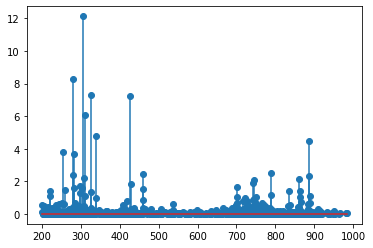

In [9]:
plt.stem(to_mz(s_m_1000), to_height(s_m_1000), use_line_collection=True)
plt.show()

In [79]:
from scipy.signal import find_peaks

def density_pm(pm, bandwidth, thresh, mz_begin, mz_end):
    pks = [mx.peak(0, p[0].mz, 1.0, bandwidth) for p in pm]
    xi = np.linspace(mz_begin, mz_end, 1000)
    yi = np.array(mx.splat_peaks(pks, xi, 4.0))
    ii, _  = find_peaks(yi)
    return (xi, yi, xi[ii], yi[ii])

594


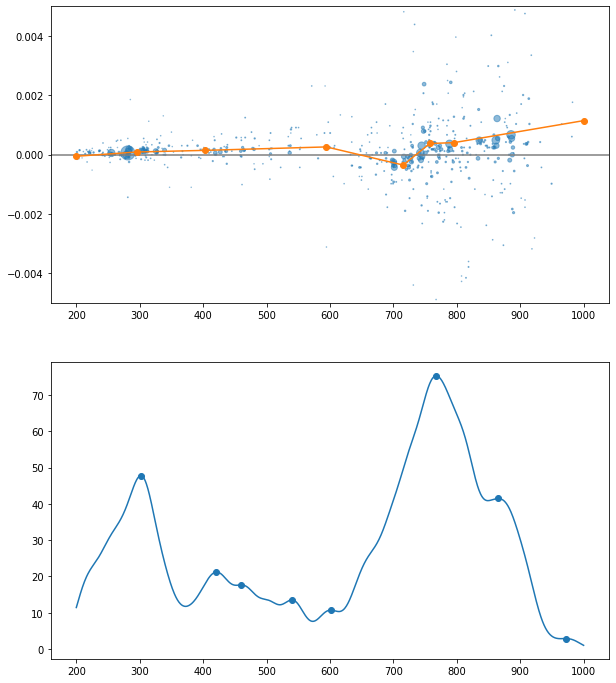

In [139]:
from msiwarp.util.warp import plot_peak_matches, plot_warping

i_s = np.random.choice(len(spectra))
s_s = spectra[i_s]

recal = warping_funcs[i_s]
xw = np.array([w[0] for w in recal])
yw = np.array([w[1] for w in recal])

pms = mx.overlapping_peak_pairs(s_ref, s_s, epsilon)
(xi, yi, xp, yp) = density_pm(pms, 15, 0.0, mz_begin, mz_end)
n_peak_matches = len(pms)
print(n_peak_matches)
    
_, axs = plt.subplots(2, 1, figsize=(10,12))
axs[0].axhline(0, c='tab:gray')
plot_peak_matches(pms, 0.5, 200, ax=axs[0])
axs[0].plot(xw, -yw, '-o', c='tab:orange')
axs[0].set_ylim([-0.005, 0.005])
axs[1].plot(xi, yi)
axs[1].scatter(xp, yp)
plt.show()

using existing scatter plot output directory


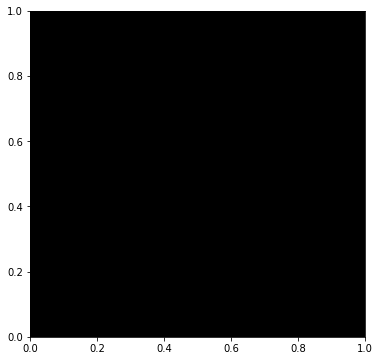

In [14]:
# ---------- plot mass scatter around mean spectrum peaks ----------
from msiwarp.util.warp import plot_range

mass_tolerance = 4 # ppm

import os

if not os.path.exists(fpath_scatter):    
    os.makedirs(fpath_scatter)
    print("made scatter plot output directory")
else:
    print("using existing scatter plot output directory")
    
fig, ax = plt.subplots(figsize=(6,6))
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ 350 ppm around reference mass 
    mz0 = mz_i - d
    mz1 = mz_i + d    
    
    plot_range(fpath_triplets_raw, mz0, mz1, ax, 'tab:cyan', 5, in_ppm=True)
    plot_range(fpath_triplets_warped, mz0, mz1, ax, 'tab:orange', 5, in_ppm=True)
    
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_title('m/z {:0.3f}'.format(mz_i))
    ax.set_xticks([-mass_tolerance, 0, mass_tolerance])
    
    fig.savefig(fpath_scatter + '/mz_{}.png'.format(int(mz_i)), dpi=200)
    ax.cla()

In [15]:
# ---------- compute mass dispersions around mean spectrum ----------
from msiwarp.util.warp import dispersion_triplets
import pandas as pd

dispersion_raw = np.zeros(len(mz_ref))
dispersion_warped = np.zeros(len(mz_ref))
    
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ 350 ppm around reference mass
    mz0 = mz_i - d
    mz1 = mz_i + d
    
    ts_raw = mx.get_triplets_range(fpath_triplets_raw, mz0, mz1)
    ts_warped = mx.get_triplets_range(fpath_triplets_warped, mz0, mz1)
    
    q = 0.0 # remove background signal
    if len(ts_raw) > 0:
        dispersion_raw[i] = dispersion_triplets(ts_raw,  q)
    if len(ts_warped) > 0:  
        dispersion_warped[i] = dispersion_triplets(ts_warped, q)


d = {'mz': mz_ref,
     'dispersion raw [ppm]': dispersion_raw,
     'dispersion warped [ppm]': dispersion_warped}

df = pd.DataFrame(d)
df.round(4).to_csv(fpath_dispersion_csv, index=False)

print('median mass dispersion raw: {:0.4f}'.format(np.median(dispersion_raw)))
print('median mass dispersion warped: {:0.4f}'.format(np.median(dispersion_warped)))

median mass dispersion raw: 0.5805
median mass dispersion warped: 0.3385


In [100]:
# convert back to pyimzml format
from pyimzml.ImzMLWriter import ImzMLWriter

output_imzml = fdir + 'output.imzML'

with ImzMLWriter(output_imzml) as w:
    for s_i, coords in zip(warped_spectra, p.coordinates):
        # writes data to the .ibd file
        w.addSpectrum(to_mz(s_i), to_height(s_i), coords)